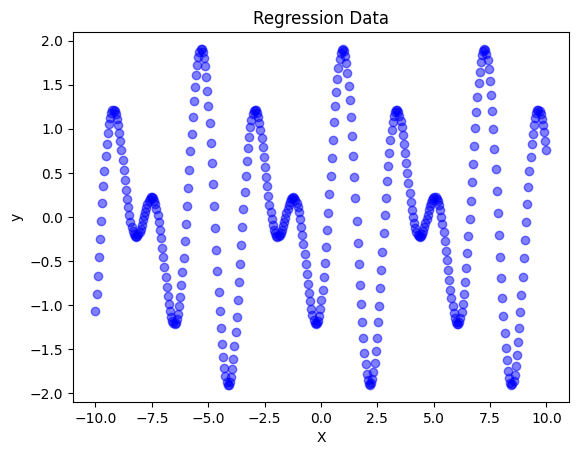

X shape: (400, 1) | y shape: (400, 1)


In [134]:
from typing import List, Tuple, Any
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Regression data
X_reg = np.linspace(-10, 10, 400).reshape(-1, 1)
y_reg = np.sin(2 * X_reg) - np.cos(3 * X_reg)

plt.scatter(X_reg, y_reg, color="blue", alpha=0.5)
plt.title("Regression Data")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

print(f"X shape: {X_reg.shape} | y shape: {y_reg.shape}")

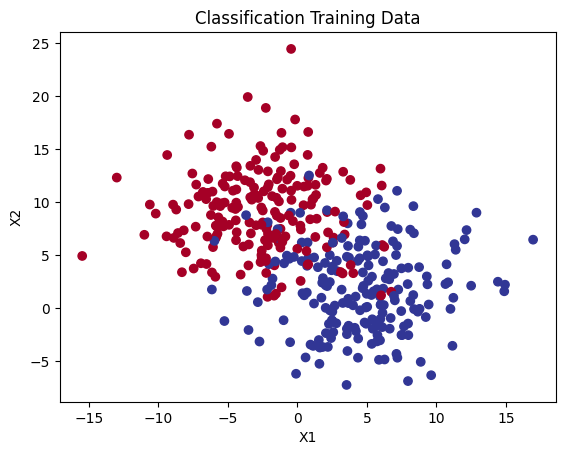

X shape: (400, 2) | y shape: (400, 1)


In [135]:
from sklearn.datasets import make_blobs

X_cls, y_cls = make_blobs(
    n_samples=400, n_features=2, centers=2, cluster_std=4, random_state=42
)
y_cls = y_cls.reshape(-1, 1)

plt.scatter(X_cls.transpose()[0], X_cls.transpose()[1], c=y_cls, cmap="RdYlBu")
plt.title("Classification Training Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

print(f"X shape: {X_cls.shape} | y shape: {y_cls.shape}")

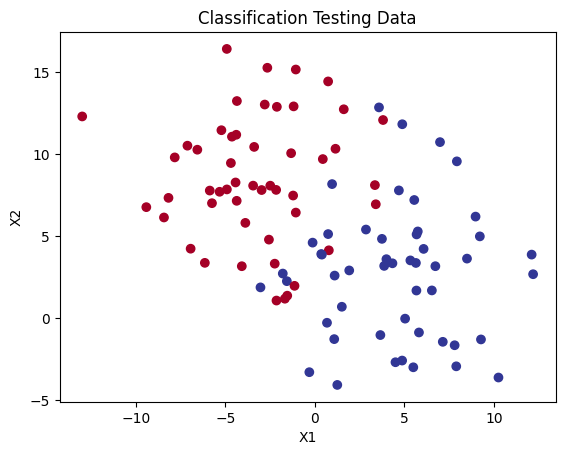

X shape: (100, 2) | y shape: (100, 1)


In [136]:
X_cls_test, y_cls_test = make_blobs(
    n_samples=100, n_features=2, centers=2, cluster_std=4, random_state=42
)
y_cls_test = y_cls_test.reshape(-1, 1)

plt.scatter(
    X_cls_test.transpose()[0], X_cls_test.transpose()[1], c=y_cls_test, cmap="RdYlBu"
)
plt.title("Classification Testing Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

print(f"X shape: {X_cls_test.shape} | y shape: {y_cls_test.shape}")

In [137]:
class ActivationFunctions:
    @staticmethod
    def ReLU(x):
        return np.maximum(0, x)

    @staticmethod
    def ReLU_derivative(x):
        return (x > 0).astype(float)

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-1 * x))

    @staticmethod
    def sigmoid_derivative(x):
        sigmoid_activation = ActivationFunctions.sigmoid(x)
        return sigmoid_activation * (1 - sigmoid_activation)

In [138]:
class LossFunctions:
    @staticmethod
    def MSELoss(y_pred, y):
        assert y_pred.size == y.size, "y_pred and y have to be the same size"

        loss_item = np.mean((y_pred - y) ** 2)
        loss_derivative = (2 / y.shape[0]) * (y_pred - y)

        # Return the loss and the partial derivative of the loss
        return loss_item, loss_derivative

    @staticmethod
    def BinaryCrossEntropyLoss(y_pred, y):
        eps = 1e-8
        assert y_pred.size == y.size, "y_pred and y have to be the same size"

        loss_item = -1 * np.mean(
            y * np.log(y_pred + eps) + (1 - y) * np.log(1 - y_pred + eps)
        )
        loss_derivative = (1 / y.shape[0]) * (
            (y_pred - y) / ((y_pred + eps) * (1 - y_pred + eps))
        )

        # Return the loss and the partial derivative of the loss
        return loss_item, loss_derivative

In [139]:
class NeuralNetwork:
    """
    Custom Feedforward Neural Network Implementation with Python and Numpy

    :param layers: A list of tuples, with each tuple representing a layer (number of input features, number of output features, activation function, activation function derivative)
    """

    def __init__(self, layers: List[Tuple[int, int, Any, Any]]):
        self.layers = []

        for layer in layers:
            weight = np.random.randn(layer[0], layer[1]) * 0.05
            bias = np.zeros((1, layer[1]))

            self.layers.append(
                {
                    "weight": weight,
                    "bias": bias,
                    "activation": layer[2],
                    "activation_derivative": layer[3],
                }
            )

    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        # Forward Pass
        # X shape: (N, num_feaures)

        output = X
        layer_outputs = {}
        layer_outputs["a_-1"] = X

        for i in range(len(self.layers)):
            layer = self.layers[i]

            output = np.dot(output, layer["weight"]) + layer["bias"]
            layer_outputs[f"z_{i}"] = output

            if layer["activation"] is not None:
                output = layer["activation"](output)

            layer_outputs[f"a_{i}"] = output

        return output, layer_outputs

    def backward(self, layer_outputs, loss, lr):
        _, loss_derivative = loss

        current_grad = loss_derivative
        for i in range(len(self.layers))[::-1]:
            layer = self.layers[i]
            weight = layer["weight"]

            if layer["activation_derivative"] is not None:
                current_grad *= layer["activation_derivative"](layer_outputs[f"z_{i}"])

            weight_grad = np.dot(layer_outputs[f"a_{i - 1}"].T, current_grad)
            bias_grad = np.sum(current_grad, axis=0, keepdims=True)

            current_grad = np.dot(current_grad, weight.T)

            # Gradient descent update
            layer["weight"] -= lr * weight_grad
            layer["bias"] -= lr * bias_grad

In [140]:
# Regression
regression_layers = [
    (1, 128, ActivationFunctions.ReLU, ActivationFunctions.ReLU_derivative),
    (128, 128, ActivationFunctions.ReLU, ActivationFunctions.ReLU_derivative),
    (128, 1, None, None),
]

regression_model = NeuralNetwork(layers=regression_layers)

test_input = np.random.randn(*X_reg.shape)
test_output, layer_outputs = regression_model(test_input)

print(f"Test Input Shape: {test_input.shape} | Test Output Shape: {test_output.shape}")

Test Input Shape: (400, 1) | Test Output Shape: (400, 1)


Epoch 1000, MSE Loss: 0.8847
Epoch 2000, MSE Loss: 0.7043
Epoch 3000, MSE Loss: 0.6144
Epoch 4000, MSE Loss: 0.6177
Epoch 5000, MSE Loss: 0.5789
Epoch 6000, MSE Loss: 0.5020
Epoch 7000, MSE Loss: 0.4461
Epoch 8000, MSE Loss: 0.3905
Epoch 9000, MSE Loss: 0.3936
Epoch 10000, MSE Loss: 0.4137


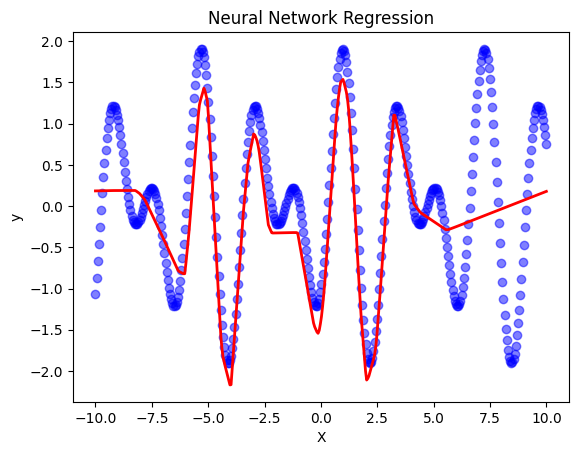

In [141]:
# Regression training
epochs = 10000
lr = 1e-1

for epoch in range(epochs):
    # Forward pass
    y_pred, layer_outputs = regression_model(X_reg)

    # Calculate the loss
    loss = LossFunctions.MSELoss(y_pred, y_reg)
    loss_item, _ = loss

    # Optimization
    regression_model.backward(layer_outputs, loss, lr)

    if (epoch + 1) % (epochs / 10) == 0:
        print(f"Epoch {epoch + 1}, MSE Loss: {loss_item:.4f}")

# Predict and plot
y_reg_pred, _ = regression_model(X_reg)

plt.scatter(X_reg, y_reg, label="Actual Data", color="blue", alpha=0.5)
plt.plot(X_reg, y_reg_pred, label="Fitted Curve", color="red", linewidth=2)
plt.title("Neural Network Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

In [149]:
# Binary Classification
classification_layers = [
    (2, 128, ActivationFunctions.ReLU, ActivationFunctions.ReLU_derivative),
    (128, 128, ActivationFunctions.ReLU, ActivationFunctions.ReLU_derivative),
    (128, 1, ActivationFunctions.sigmoid, ActivationFunctions.sigmoid_derivative),
]

classification_model = NeuralNetwork(layers=classification_layers)

test_input = np.random.randn(*X_cls.shape)
test_output, layer_outputs = classification_model(test_input)

print(f"Test Input Shape: {test_input.shape} | Test Output Shape: {test_output.shape}")

Test Input Shape: (400, 2) | Test Output Shape: (400, 1)


Epoch 200, BCE Loss: 0.3368
Epoch 400, BCE Loss: 0.2961
Epoch 600, BCE Loss: 0.2858
Epoch 800, BCE Loss: 0.2805
Epoch 1000, BCE Loss: 0.2773
Epoch 1200, BCE Loss: 0.2749
Epoch 1400, BCE Loss: 0.2730
Epoch 1600, BCE Loss: 0.2713
Epoch 1800, BCE Loss: 0.2699
Epoch 2000, BCE Loss: 0.2686
Training accuracy: 88.50%
Testing accuracy: 85.00%


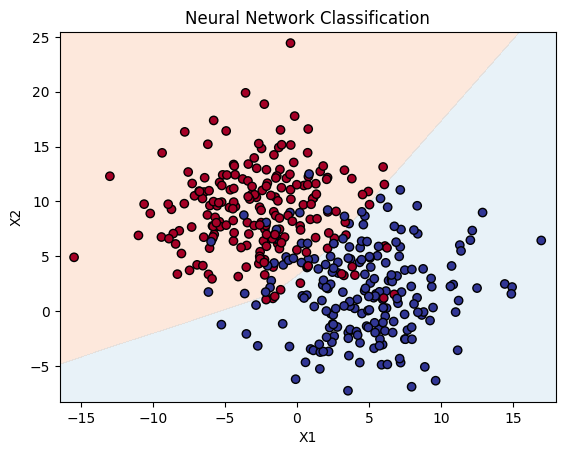

In [150]:
# Classification training
epochs = 2000
lr = 1e-2

for epoch in range(epochs):
    # Forward pass
    y_pred, layer_outputs = classification_model(X_cls)

    # Calculate the loss
    loss = LossFunctions.BinaryCrossEntropyLoss(y_pred, y_cls)
    loss_item, _ = loss

    # Optimization
    classification_model.backward(layer_outputs, loss, lr)

    if (epoch + 1) % (epochs / 10) == 0:
        print(f"Epoch {epoch + 1}, BCE Loss: {loss_item:.4f}")

# Training Accuracy
y_cls_pred, _ = classification_model(X_cls)
pred_labels = (y_cls_pred > 0.5).astype(int)
train_accuracy = (pred_labels == y_cls).mean()
print(f"Training accuracy: {train_accuracy * 100:.2f}%")

# Testing Accuracy
y_cls_test_pred, _ = classification_model(X_cls_test)
test_pred_labels = (y_cls_test_pred > 0.5).astype(int)
test_accuracy = (test_pred_labels == y_cls_test).mean()
print(f"Testing accuracy: {test_accuracy * 100:.2f}%")

# Plot
x0 = np.linspace(X_cls[:, 0].min() - 1, X_cls[:, 0].max() + 1, 200)
x1 = np.linspace(X_cls[:, 1].min() - 1, X_cls[:, 1].max() + 1, 200)
xx, yy = np.meshgrid(x0, x1)
grid = np.c_[xx.ravel(), yy.ravel()]

zz, _ = classification_model(grid)
zz = zz.reshape(xx.shape)

plt.contourf(xx, yy, zz, levels=[0, 0.5, 1], alpha=0.2, cmap="RdYlBu")
plt.scatter(X_cls[:, 0], X_cls[:, 1], c=y_cls, cmap="RdYlBu", edgecolor="k")
plt.title("Neural Network Classification")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()